In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tqdm
import random
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [2]:
### READ DATA ###
df = pd.read_excel('Folds5x2_pp.xlsx')
print(df.shape)
df.head()

(9568, 5)


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


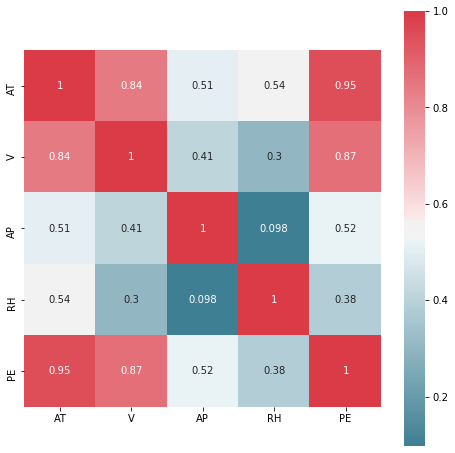

In [3]:
### PLOT CORRELATION MATRIX ###
plt.figure(figsize=(8,8))
train_size = int(df.shape[0]*0.8)
corr_matrix = df.iloc[:train_size,:].corr().abs()
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, annot=True)

In [4]:
### TRAIN TEST SPLIT ###
X, y = ['AT','V','AP','RH'], ['PE']
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size = 0.2, random_state = 42)

# GRADIENT BOOSTING FEATURE IMPORTANCES

In [5]:
### FIT GRADIENTBOOSTING ###
rf = GradientBoostingRegressor(n_estimators=100)
rf.fit(X_train, y_train.values.ravel())

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
### PREDICTION ERROR ON TEST DATA ###
mean_absolute_error(y_test, rf.predict(X_test))

2.947613064419067

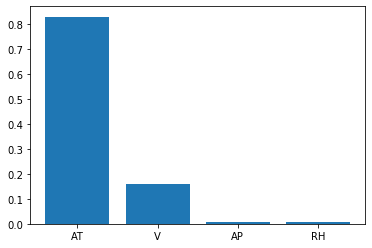

In [7]:
### FEATURE IMPORTANCES REPORT ###
plt.bar(range(X_train.shape[1]), rf.feature_importances_)
plt.xticks(range(X_train.shape[1]), ['AT','V','AP','RH'])
np.set_printoptions(False)

# PERMUTATION IMPORTANCE

In [8]:
### SCALE DATA FOR NN ###
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

In [9]:
### SET SEED ###
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


### DEFINE NN STRUCTURE ###

inp = Input(shape=(scaled_train.shape[1],))
x = Dense(128, activation='relu')(inp)
x = Dense(32, activation='relu')(x)
out = Dense(1)(x)

model = Model(inp, out)
model.compile(optimizer='adam', loss='mse')

In [10]:
### FIT NN ###
model.fit(scaled_train, ((y_train - y_train.mean())/y_train.std()).values , epochs=100, batch_size=128 ,verbose=2)

Train on 7654 samples
Epoch 1/100
7654/7654 - 1s - loss: 0.2597
Epoch 2/100
7654/7654 - 0s - loss: 0.0659
Epoch 3/100
7654/7654 - 0s - loss: 0.0618
Epoch 4/100
7654/7654 - 0s - loss: 0.0608
Epoch 5/100
7654/7654 - 0s - loss: 0.0599
Epoch 6/100
7654/7654 - 0s - loss: 0.0599
Epoch 7/100
7654/7654 - 0s - loss: 0.0595
Epoch 8/100
7654/7654 - 0s - loss: 0.0588
Epoch 9/100
7654/7654 - 0s - loss: 0.0584
Epoch 10/100
7654/7654 - 0s - loss: 0.0587
Epoch 11/100
7654/7654 - 0s - loss: 0.0581
Epoch 12/100
7654/7654 - 0s - loss: 0.0581
Epoch 13/100
7654/7654 - 0s - loss: 0.0575
Epoch 14/100
7654/7654 - 0s - loss: 0.0574
Epoch 15/100
7654/7654 - 0s - loss: 0.0574
Epoch 16/100
7654/7654 - 0s - loss: 0.0575
Epoch 17/100
7654/7654 - 0s - loss: 0.0571
Epoch 18/100
7654/7654 - 0s - loss: 0.0569
Epoch 19/100
7654/7654 - 0s - loss: 0.0573
Epoch 20/100
7654/7654 - 0s - loss: 0.0563
Epoch 21/100
7654/7654 - 0s - loss: 0.0564
Epoch 22/100
7654/7654 - 0s - loss: 0.0561
Epoch 23/100
7654/7654 - 0s - loss: 0.056

In [11]:
### PREDICTION ERROR ON TEST DATA ###
real_pred = model.predict(scaled_test).ravel() * y_train.std()[0] + y_train.mean()[0]
MAE = mean_absolute_error(y_test, model.predict(scaled_test).ravel() * y_train.std()[0] + y_train.mean()[0])
MAE

2.9543384107950463

In [12]:
### COMPUTE PERMUTATION AND SCORING ###
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

final_score = []
shuff_pred = []

for i,col in enumerate(X_test.columns):

    # shuffle column
    shuff_test = scaled_test.copy()
    shuff_test[:,i] = np.random.permutation(shuff_test[:,i])
    
    # compute score
    score = mean_absolute_error(y_test, model.predict(shuff_test).ravel() *y_train.std()[0]+y_train.mean()[0])
    shuff_pred.append(model.predict(shuff_test).ravel() *y_train.std()[0]+y_train.mean()[0])
    final_score.append(score)
    
final_score = np.asarray(final_score)

In [13]:
final_score

array([17.,  6.,  4.,  4.])

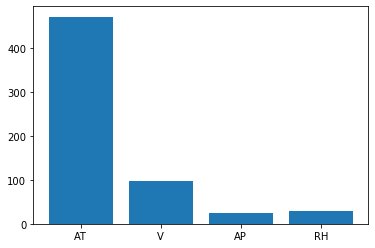

In [14]:
### PERMUTATION IMPORTANCE REPORT ###
plt.bar(range(X_train.shape[1]), (final_score - MAE)/MAE*100)
plt.xticks(range(X_train.shape[1]), ['AT','V','AP','RH'])
np.set_printoptions(False)

# EXPLAIN CASUALITY

In [15]:
### SIMULATE MEAN DIFFERENCE TEST AMONG PREDICTIONS ###
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

id_ = 0

merge_pred = np.hstack([shuff_pred[id_], real_pred])
observed_diff = abs(shuff_pred[id_].mean() - merge_pred.mean())
extreme_values = []
sample_d = []

for _ in range(10000):
    sample_mean = np.random.choice(merge_pred, size=shuff_pred[id_].shape[0]).mean()
    sample_diff = abs(sample_mean - merge_pred.mean())
    sample_d.append(sample_diff)
    extreme_values.append(sample_diff >= observed_diff)
    
np.sum(extreme_values)/10000

0.0253

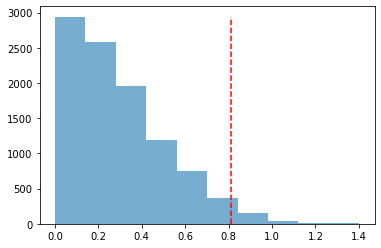

In [16]:
### PLOT MEAN DIFFERENCE DISTRIBUTIONS ###
y, x, _ = plt.hist(sample_d, alpha=0.6)
plt.vlines(observed_diff, 0,max(y), colors='red', linestyles='dashed')